In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
from db_queries import get_population

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data/'

In [37]:
scenarios = ['baseline','lifestyle_100','outreach_100','polypill_100']
cols = ['input_draw','scenario'] #,'sex','age']
location = 'alaska'

In [61]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths = deaths.loc[#(deaths.cause.isin(['acute_ischemic_stroke','chronic_ischemic_stroke']))
                    (deaths.location == location)].drop(columns='Unnamed: 0')
deaths = deaths.groupby(cols).sum()[['value']].reset_index()
deaths.head()

,input_draw,scenario,value
0,29,baseline,10139.0
1,29,lifestyle_100,10106.0
2,29,outreach_100,10109.0
3,29,polypill_100,9987.0
4,232,baseline,9486.0


In [59]:
def calc_averted_counts(baseline_scenario):
    draw_comparison = pd.DataFrame()
    for i in list(range(0,len(deaths.input_draw.unique()))):
        random_draws = deaths.input_draw.unique()[0:i+1]
        count = deaths.loc[deaths.input_draw.isin(random_draws)]
        data = count #* 100_000).reset_index()
        data_baseline = data.loc[data.scenario==baseline_scenario]
        data_averted = (data_baseline.set_index([c for c in data.columns if c != 'value' and c != 'scenario']).drop(columns='scenario')
                        - data.set_index([c for c in data.columns if c != 'value' and c != 'scenario'] + ['scenario'])).reset_index()
        data_averted['baseline_scenario'] = baseline_scenario
        data_averted['n_draws'] = i
        data_averted = data_averted.groupby(['input_draw','scenario','baseline_scenario','n_draws']).value.describe(percentiles=[0.025,0.975]).reset_index()
        draw_comparison = pd.concat([draw_comparison, data_averted], ignore_index=True)
    return draw_comparison

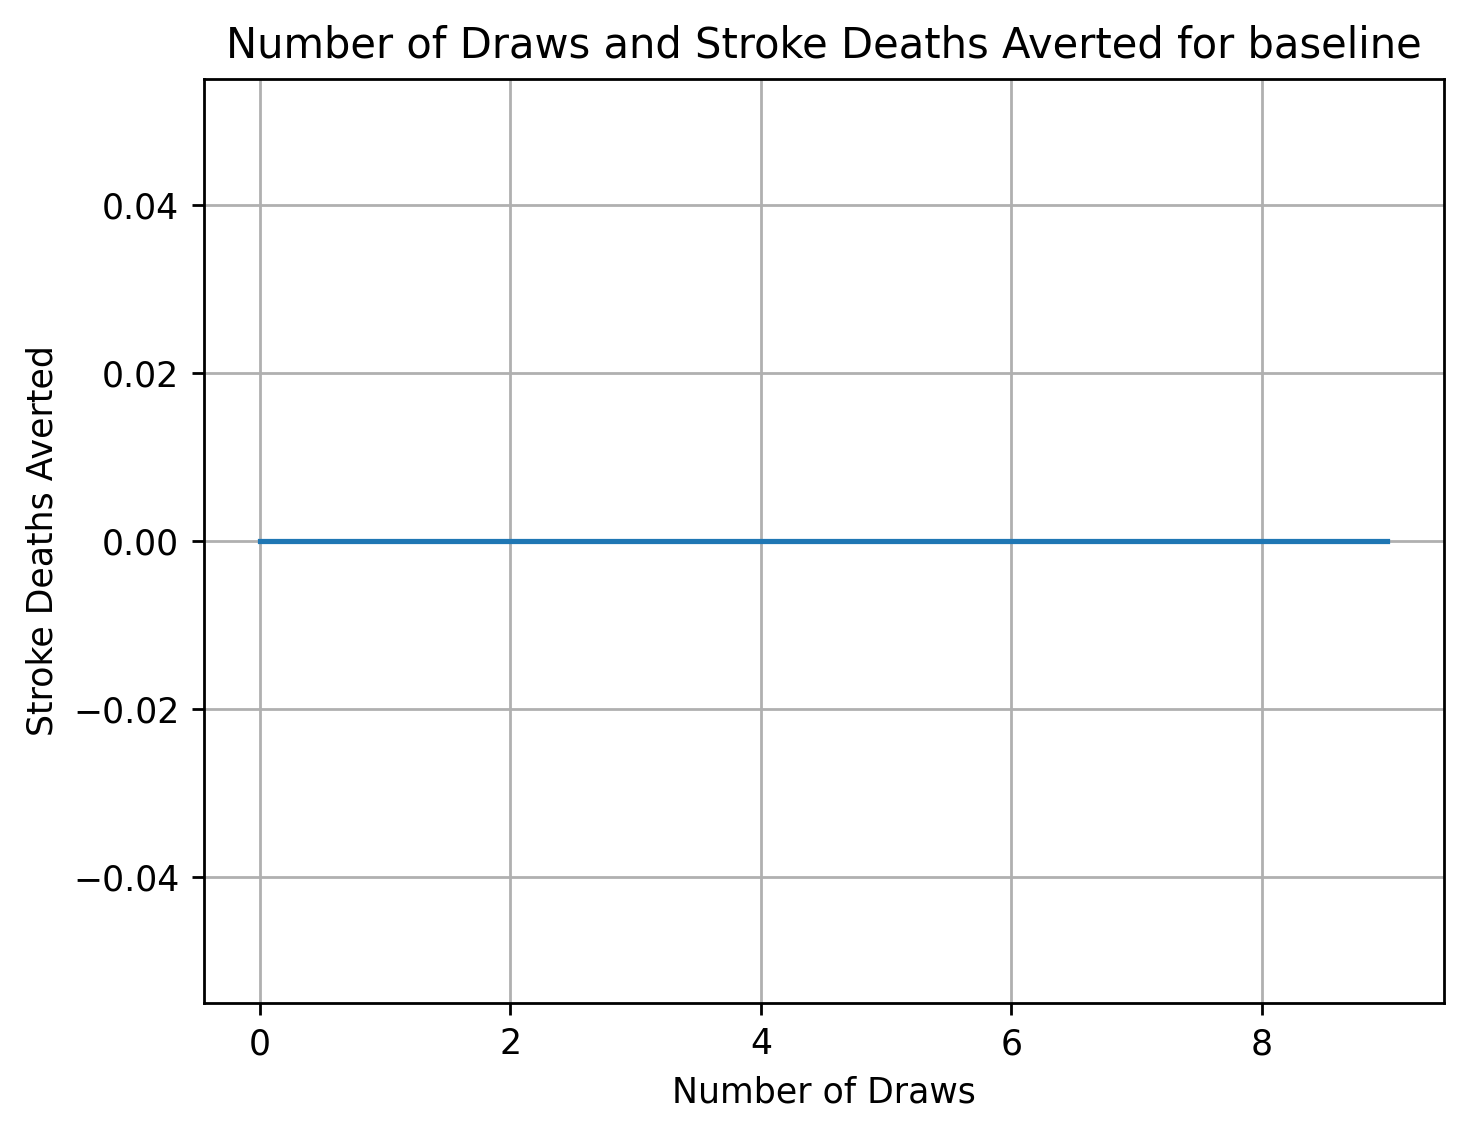

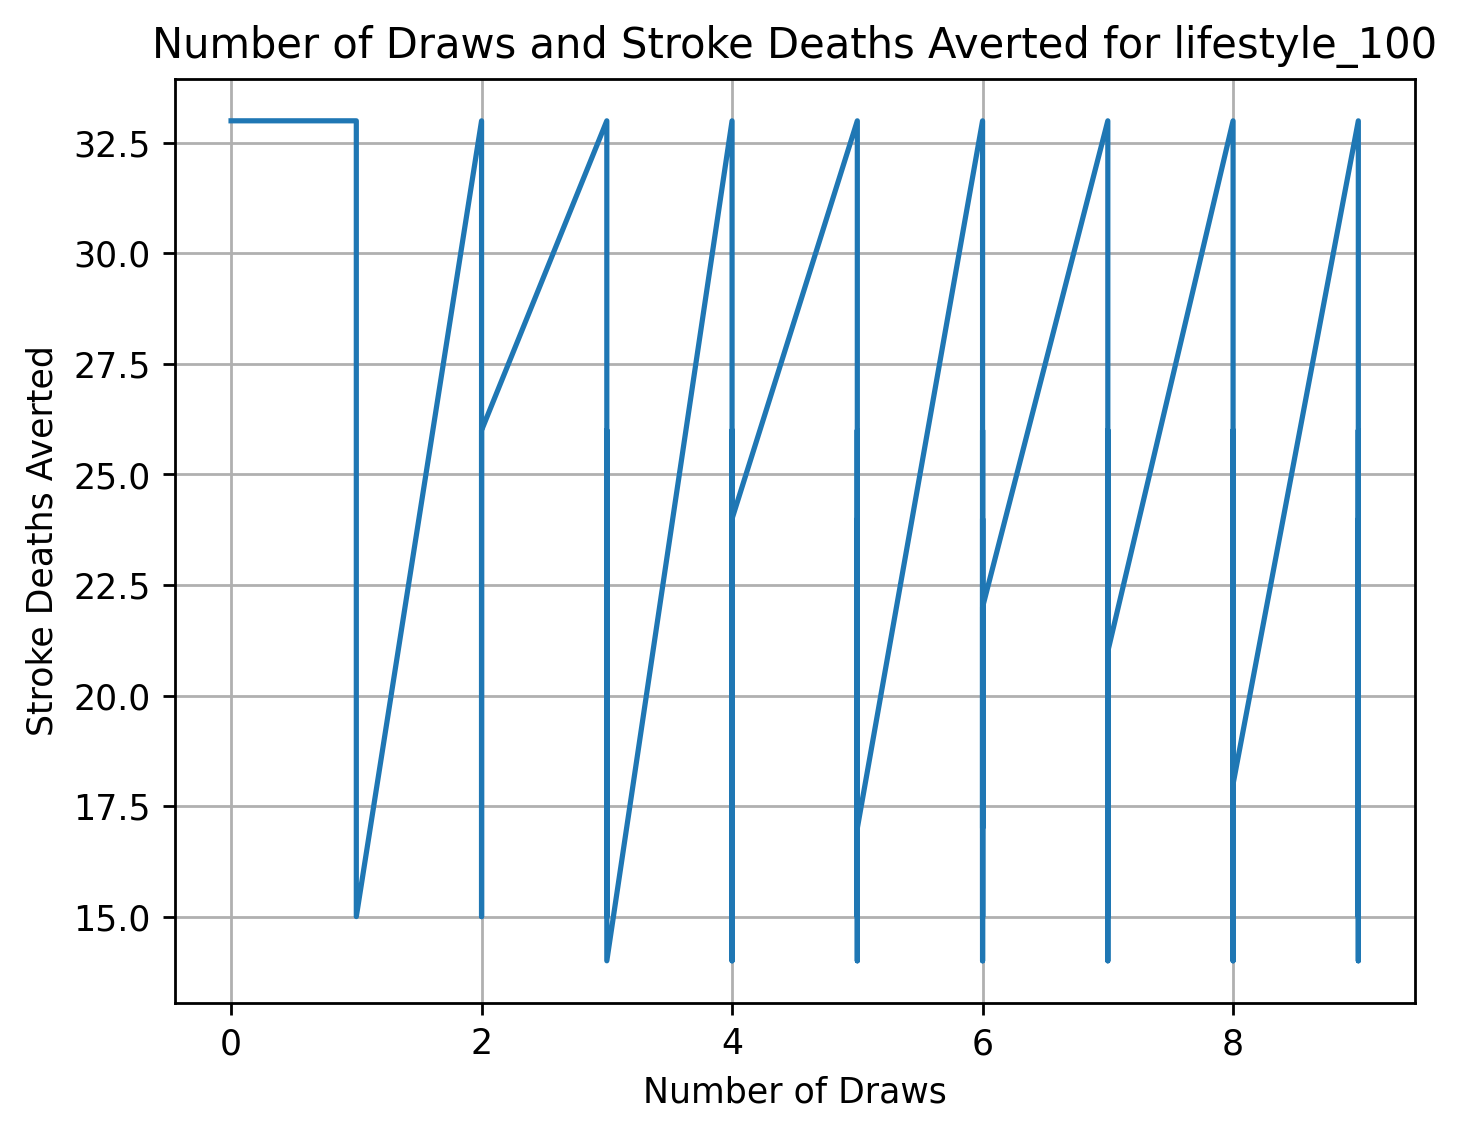

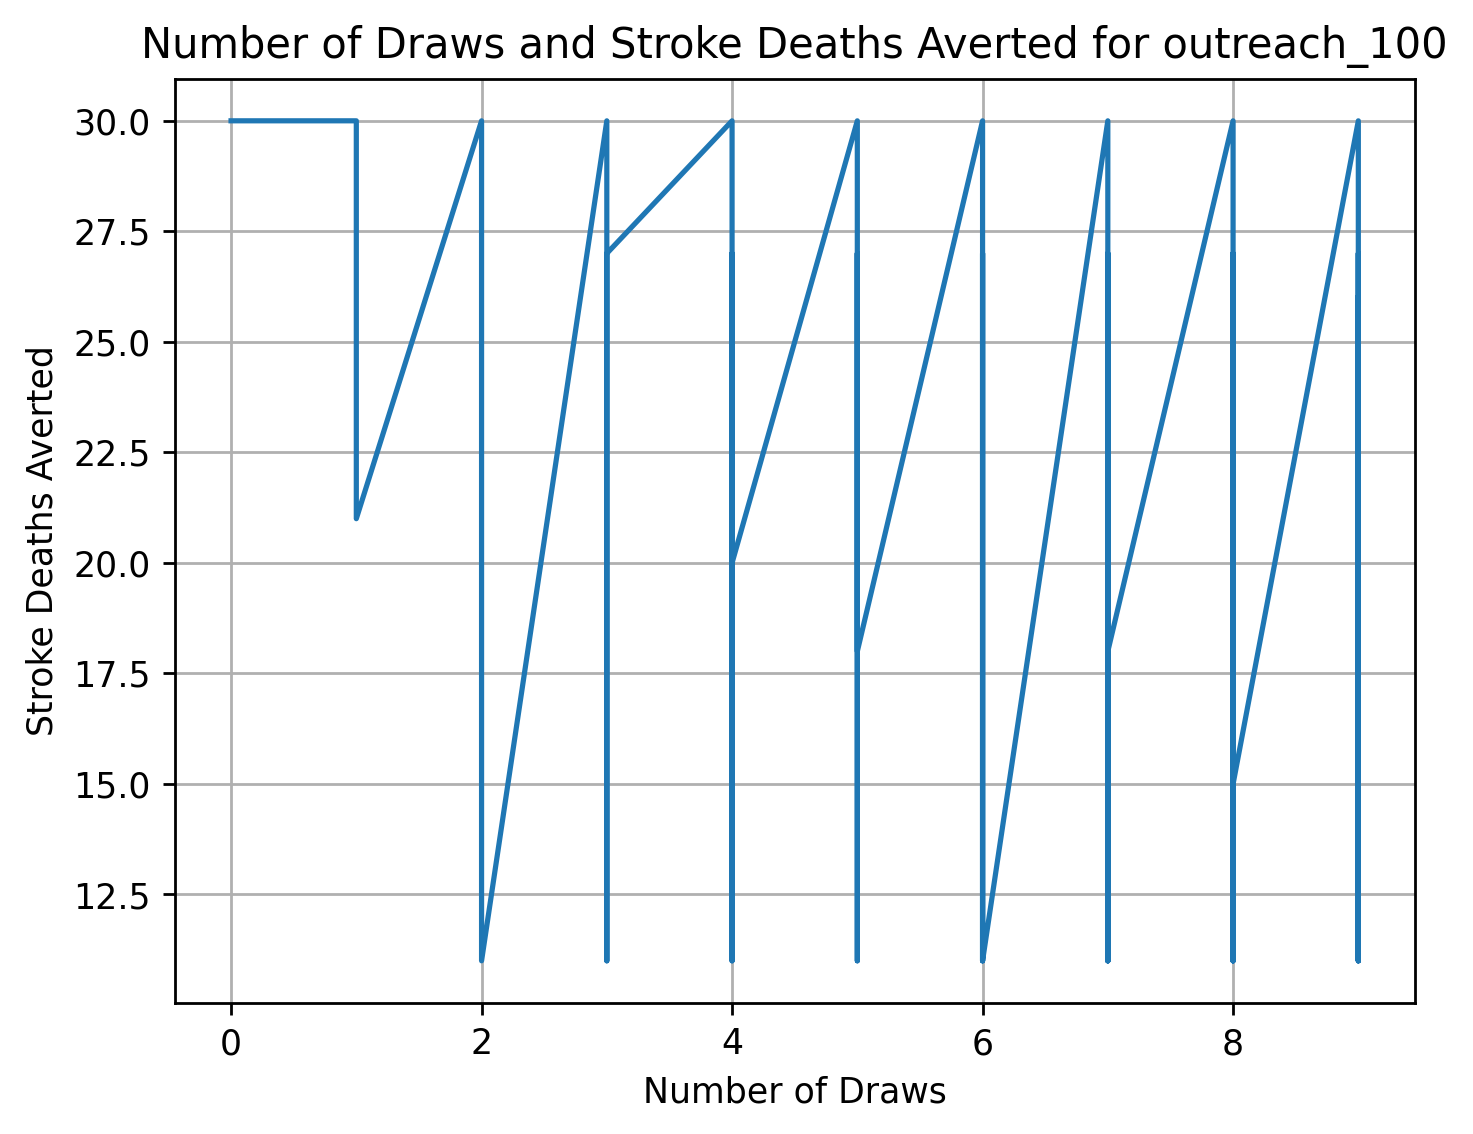

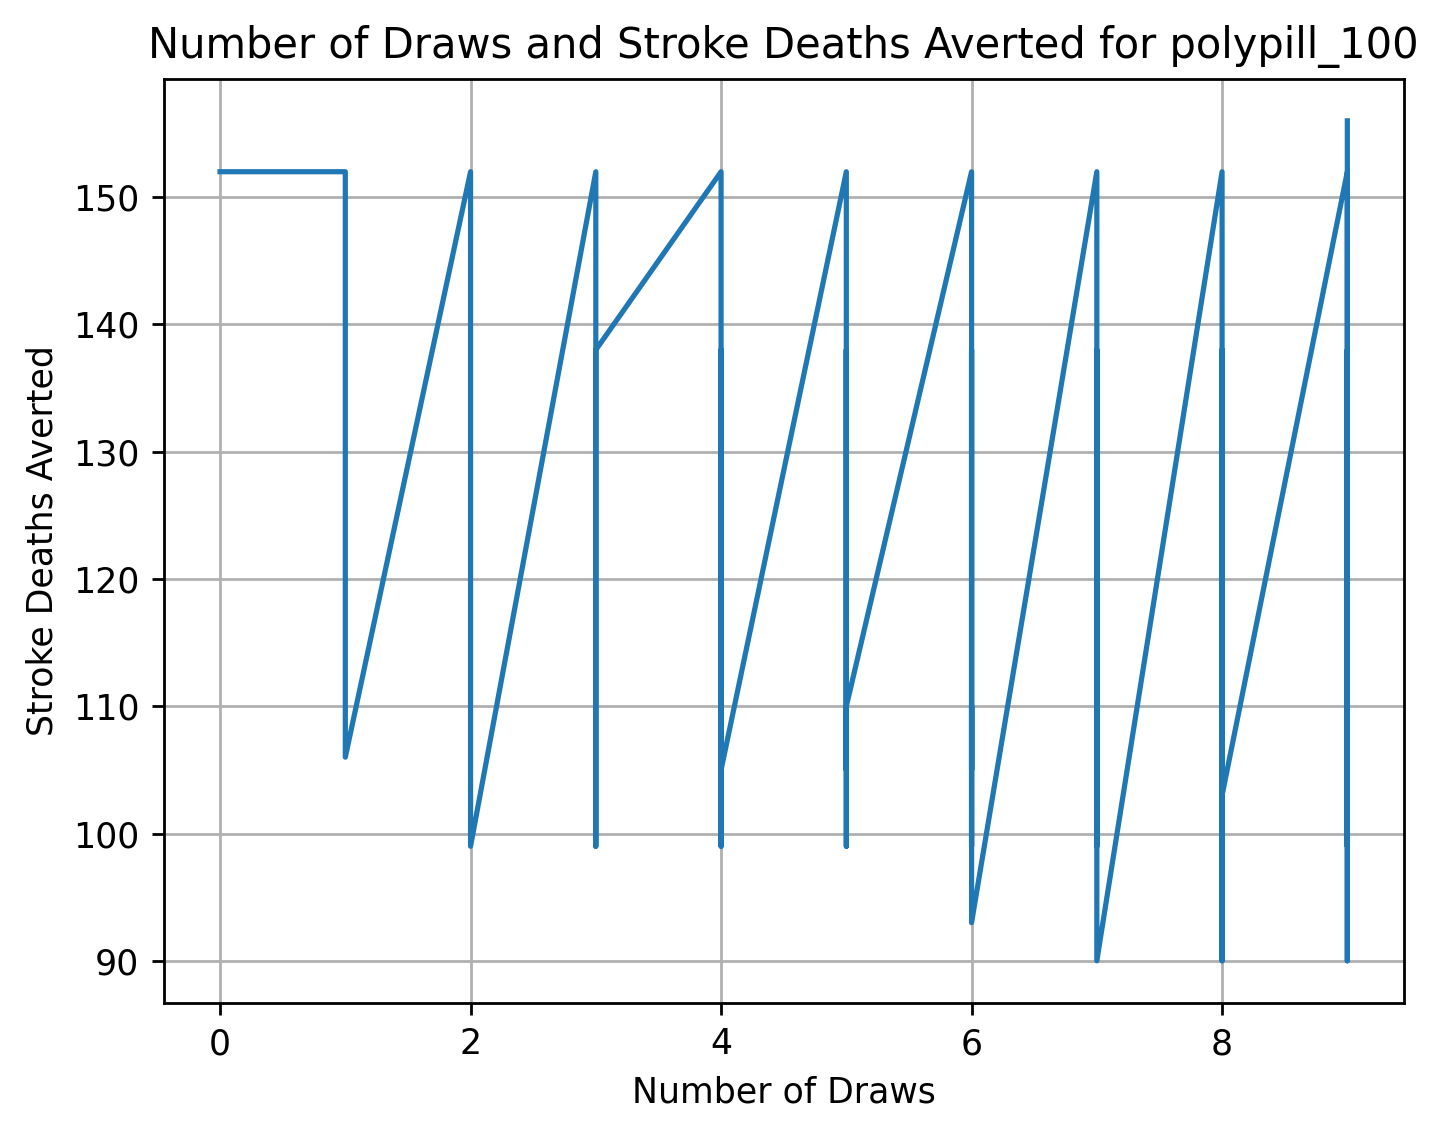

In [62]:
baseline_scenario = 'baseline'
draw_comparison = calc_averted_counts(baseline_scenario)

for scenario in scenarios:
    plt.figure(dpi=250)
    p = draw_comparison.loc[(draw_comparison.scenario==scenario)]

    plt.plot(p['n_draws'], p['mean'])
    plt.fill_between(p['n_draws'], p['2.5%'], p['97.5%'], alpha=0.2)

    plt.grid()
    plt.ylabel('Stroke Deaths Averted')
    plt.xlabel('Number of Draws')
    plt.title(f'Number of Draws and Stroke Deaths Averted for {scenario}')